This note book runs on Google's colab, with simple modification one can also run it lacally.

## Download data

In [0]:
!mkdir data && cd data && wget http://files.grouplens.org/datasets/movielens/ml-1m.zip && unzip ml-1m.zip

In [0]:
!cd data && wget http://files.grouplens.org/datasets/movielens/ml-20m.zip && unzip ml-20m.zip

Here we use tensorflow 2.0 which has some nice features, including Metric class.

In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1

In [0]:
import tensorflow as tf
import tensorflow.keras as kr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
print("GPU Available: ", tf.test.is_gpu_available())

GPU Available:  True


In [6]:
tf.__version__

'2.0.0-beta1'

## ml-1m data

In [0]:
ratings = pd.read_csv('./data/ml-1m/ratings.dat', delimiter='::', names=['userId', 'movieId', 'rating', 'timeStamp'])
num_user = ratings.userId.nunique()
num_movie = ratings.movieId.nunique()

### construct rating matrix

Some users or movies may not in the ratings. We need to create a dict to map the col/row to the real userId and movieId

In [0]:
user_dict = {}
movie_dict = {}
n_mapped_user = 0
n_mapped_movie = 0
R = np.zeros((num_user, num_movie))
for index, row in ratings.iterrows():
  if row.userId in user_dict:
    user_cur = user_dict[row.userId]
  else:
    user_cur = n_mapped_user
    n_mapped_user += 1
    user_dict[row.userId] = user_cur
  if row.movieId in movie_dict:
    movie_cur = movie_dict[row.movieId]
  else:
    movie_cur = n_mapped_movie
    n_mapped_movie += 1
    movie_dict[row.movieId] = movie_cur
  R[user_cur, movie_cur] = row.rating

### train-test split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
R_train, R_test = train_test_split(R, test_size=0.1)

## Loss and metrics function

In [0]:
def simple_loss(y_true, y_pred):
    err_sq = tf.square(y_true - y_pred)
    is_rated = tf.cast(tf.not_equal(y_true, 0.0), y_true.dtype)
    return tf.reduce_sum(err_sq*is_rated, axis=-1)/tf.reduce_sum(is_rated, axis=-1)

In [0]:
# need tensorflow 2.0
class SimpleMetric(kr.metrics.Metric):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.total = self.add_weight('total', initializer='zeros')
        self.count = self.add_weight('count', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        err_sq = tf.square(y_true - y_pred)
        is_rated = tf.cast(tf.not_equal(y_true, 0.0), y_true.dtype)
        self.total.assign_add(tf.reduce_sum(err_sq*is_rated))
        self.count.assign_add(tf.reduce_sum(is_rated))
    def result(self):
        return tf.sqrt(self.total/self.count)

## Simple autoencoder

In [0]:
input_ = kr.layers.Input(shape=R.shape[1:])
hidden1 = kr.layers.Dense(600, activation='relu', kernel_regularizer=kr.regularizers.l2(0.001))(input_)
hidden2 = kr.layers.Dense(128, activation='relu', kernel_regularizer=kr.regularizers.l2(0.001))(hidden1)
hidden3 = kr.layers.Dense(600, activation='relu', kernel_regularizer=kr.regularizers.l2(0.001))(hidden2)
output_ = kr.layers.Dense(R.shape[1], kernel_regularizer=kr.regularizers.l2(0.01))(hidden3)
model = kr.Model(inputs=[input_], outputs=[output_])

In [0]:
model.compile(loss=simple_loss, optimizer='adam', metrics=[SimpleMetric(name='rmse')])

In [0]:
model.fit(R_train, R_train, validation_data=(R_test, R_test), epochs=100, callbacks=[kr.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

### evaluate on train and test set

In [0]:
model.evaluate(R_train, R_train)

5436/5436 [==============================] - 1s 129us/sample - loss: 0.9871 - rmse: 0.9170


[0.9870903274432274, 0.9170124]

In [0]:
model.evaluate(R_test, R_test)

604/604 [==============================] - 0s 147us/sample - loss: 1.1796 - rmse: 0.9866


[1.1796246782833377, 0.9865769]

## Denoising autoencoder

In [0]:
input_ = kr.layers.Input(shape=R.shape[1:])
dropout = kr.layers.Dropout(0.025)(input_)
hidden1 = kr.layers.Dense(600, activation='relu', kernel_regularizer=kr.regularizers.l2(0.001))(dropout)
hidden2 = kr.layers.Dense(128, activation='relu', kernel_regularizer=kr.regularizers.l2(0.001))(hidden1)
hidden3 = kr.layers.Dense(600, activation='relu', kernel_regularizer=kr.regularizers.l2(0.001))(hidden2)
output_ = kr.layers.Dense(R.shape[1], kernel_regularizer=kr.regularizers.l2(0.001))(hidden3)
model_dae = kr.Model(inputs=[input_], outputs=[output_])

In [0]:
model_dae.compile(loss=simple_loss, optimizer='adam', metrics=[SimpleMetric(name='rmse')])

In [0]:
model_dae.fit(R_train, R_train, validation_data=(R_test, R_test), epochs=100, callbacks=[kr.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

### evaluate on train and test set

In [0]:
model_dae.evaluate(R_train, R_train)

5436/5436 [==============================] - 1s 132us/sample - loss: 0.9302 - rmse: 0.8868


[0.9301822196919748, 0.8867864]

In [0]:
model_dae.evaluate(R_test, R_test)

604/604 [==============================] - 0s 149us/sample - loss: 1.1588 - rmse: 0.9633


[1.1587914165282092, 0.963341]

## ml-20m data

This data set is too large to create a numpy ratings matrix

In [0]:
ratings = pd.read_csv('./data/ml-20m/ratings.csv', delimiter=',')
num_user = ratings.userId.nunique()
num_movie = ratings.movieId.nunique()

### convert to tfrecord format

In [0]:
ratings.sort_values('userId', inplace=True)

Convert the large dataset into tfrecord format

In [0]:
movie_dict = {}
n_mapped_user = 0
n_mapped_movie = 0
users_per_file = 1000
counter = 0
n_files = 1
cur_data = []
rate_array = None
user_cur = 0
f = tf.io.TFRecordWriter('./data/ml-20m/ratings_'+str(n_files)+'.tfrecord')
for index, row in ratings.iterrows():
  if row.userId != user_cur:
    if rate_array is not None:
      example = tf.train.Example(features=tf.train.Features(feature={'movie_ratings': tf.train.Feature(float_list=tf.train.FloatList(value=rate_array))}))
      f.write(example.SerializeToString())
    if counter == users_per_file:
      counter = 0
      print('{} record saved!'.format(n_files))
      f.close()
      n_files += 1
      f = tf.io.TFRecordWriter('./data/ml-20m/ratings_'+str(n_files)+'.tfrecord')
    counter += 1
    rate_array = np.zeros(num_movie)
    user_cur = row.userId
  if row.movieId in movie_dict:
    movie_cur = movie_dict[row.movieId]
  else:
    movie_cur = n_mapped_movie
    n_mapped_movie += 1
    movie_dict[row.movieId] = movie_cur
  rate_array[movie_cur] = row.rating
print('{} record saved!'.format(n_files))
f.close()

save the one-to-one map between index and movieId

In [0]:
import pickle
with open("./data/ml-20m/movie_map.pkl","wb") as f:
  pickle.dump(movie_dict, f)

Save to google drive

In [0]:
!pip install -U -q PyDrive

In [0]:
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo
!mv /tmp/colab_util_repo/colab_util.py colab_util.py 
!rm -r /tmp/colab_util_repo
from colab_util import *
import glob

In [0]:
drive_handler = GoogleDriveHandler()

In [0]:
data_files = glob.glob('./data/ml-20m/ratings_*')
tar_file_path = create_archive('data_archive', local_file_paths=data_files, verbose=True)
drive_handler.upload(tar_file_path, parent_path='ml_data')

In [0]:
drive_handler.upload('./data/ml-20m/movie_map.pkl', parent_path='ml_data')

### Read tfrecord files

In [0]:
data_files = glob.glob('./data/ml-20m/ratings_*')

In [0]:
train_set = data_files[:len(data_files)-10]
test_set = data_files[len(data_files)-10:]

In [0]:
R_train = tf.data.TFRecordDataset(train_set)
R_test = tf.data.TFRecordDataset(test_set)

In [0]:
def parse(serialized):
  features={'movie_ratings':tf.io.FixedLenFeature([num_movie], tf.float32), }
  parsed_example=tf.io.parse_single_example(serialized, features=features)
  movie_ratings = tf.cast(parsed_example['movie_ratings'], tf.float32)
  return movie_ratings, movie_ratings

In [0]:
R_train = R_train.map(parse)
R_test = R_test.map(parse)
R_train = R_train.shuffle(100)
R_test = R_test.shuffle(100)
R_train = R_train.batch(32).prefetch(1)
R_test = R_test.batch(32).prefetch(1)

### simple model

In [0]:
input_ = kr.layers.Input(shape=num_movie)
hidden1 = kr.layers.Dense(600, activation='relu', kernel_regularizer=kr.regularizers.l2(0.001))(input_)
hidden2 = kr.layers.Dense(128, activation='relu', kernel_regularizer=kr.regularizers.l2(0.001))(hidden1)
hidden3 = kr.layers.Dense(600, activation='relu', kernel_regularizer=kr.regularizers.l2(0.001))(hidden2)
output_ = kr.layers.Dense(num_movie, kernel_regularizer=kr.regularizers.l2(0.01))(hidden3)
model = kr.Model(inputs=[input_], outputs=[output_])

In [0]:
model.compile(loss=simple_loss, optimizer='adam', metrics=[SimpleMetric(name='rmse'), ])

In [0]:
model.fit(R_train, validation_data=R_test, epochs=100, callbacks=[kr.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

In [0]:
model.evaluate(R_train)

   4016/Unknown - 113s 28ms/step - loss: 0.9376 - rmse: 0.9223

[0.9375908920964396, 0.9222605]

In [0]:
model.evaluate(R_test)

    313/Unknown - 9s 28ms/step - loss: 0.9437 - rmse: 0.9154

[0.9436552920661414, 0.91538346]

In [0]:
model.save('simple_20m.h5')
drive_handler.upload('./simple_20m.h5', parent_path='ml_data')

### Denoising model

In [0]:
input_ = kr.layers.Input(shape=num_movie)
dropout = kr.layers.Dropout(0.025)(input_)
hidden1 = kr.layers.Dense(600, activation='relu', kernel_regularizer=kr.regularizers.l2(0.001))(dropout)
hidden2 = kr.layers.Dense(128, activation='relu', kernel_regularizer=kr.regularizers.l2(0.001))(hidden1)
hidden3 = kr.layers.Dense(600, activation='relu', kernel_regularizer=kr.regularizers.l2(0.001))(hidden2)
output_ = kr.layers.Dense(num_movie, kernel_regularizer=kr.regularizers.l2(0.001))(hidden3)
model_dae = kr.Model(inputs=[input_], outputs=[output_])

In [0]:
model_dae.compile(loss=simple_loss, optimizer='adam', metrics=[SimpleMetric(name='rmse'), ])

In [0]:
history = model_dae.fit(R_train, validation_data=R_test, epochs=100, callbacks=[kr.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

In [25]:
model_dae.evaluate(R_train)

   4016/Unknown - 89s 22ms/step - loss: 0.9152 - rmse: 0.9058

[0.9152367430854129, 0.9057549]

In [26]:
model_dae.evaluate(R_test)

    313/Unknown - 7s 22ms/step - loss: 0.9255 - rmse: 0.9006

[0.9254574164414939, 0.9005534]

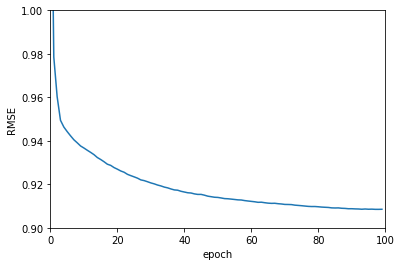

In [36]:
fig, ax = plt.subplots()
ax.plot(history.history['rmse'])
ax.set_ylim(0.9, 1)
ax.set_ylabel('RMSE')
ax.set_xlabel('epoch')
ax.set_xlim(0, 100)
fig.savefig('./learning_curve.pdf')

In [0]:
model_dae.save('denosing_20m.h5')
drive_handler.upload('./denosing_20m.h5', parent_path='ml_data')